# Data Visualizations

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
from glob import glob
import torch
from dataset import CarDataset
from model import GNN_mtl_gnn, GNN_mtl_mlp
from torch_geometric.loader import DataLoader

def visualize_multiple_csvs_as_video(csv_folder, output_video_path='intersection.mp4', interval_ms=100, max_frames=None):
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

    if not all_csvs:
        print("No CSV files found.")
        return

    df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
    df = df.sort_values(by='TIMESTAMP')

    # Normalize track IDs to assign each car a unique color
    track_ids = df['TRACK_ID'].unique()
    colors = {track_id: plt.cm.tab20(i % 20) for i, track_id in enumerate(track_ids)}

    # Group by timestamp
    timestamps = sorted(df['TIMESTAMP'].unique())
    if max_frames is not None:
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
    ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
    ax.set_aspect('equal')

    def init():
        return []

    def update(frame_idx):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
        ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
        ax.set_title(f"Time: {ts:.1f}s")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')

        road_width = 50
        ax.add_patch(plt.Rectangle((df['X'].min() - 20, -road_width / 2),
                                (df['X'].max() - df['X'].min()) + 40,
                                road_width, color='lightgray', zorder=0))
        ax.add_patch(plt.Rectangle((-road_width / 2, df['Y'].min() - 20),
                                road_width,
                                (df['Y'].max() - df['Y'].min()) + 40,
                                color='lightgray', zorder=0))

        if ts not in grouped.groups:
            return []

        frame_df = grouped.get_group(ts)

        for _, row in frame_df.iterrows():
            x = float(row['X'])
            y = float(row['Y'])
            track_id = row['TRACK_ID']
            yaw_deg = float(row['yaw'])             
            speed = float(row['speed'])
            color = colors.get(track_id, 'gray')

            # Heading for arrow (correct as is)
            heading_arrow = np.deg2rad(yaw_deg + 90)

            # Vehicle rotation (flipped horizontally)
            heading_rect = -heading_arrow

            length = 4
            width = 2
            dx = -length / 2
            dy = -width / 2

            rect = plt.Rectangle((x + dx, y + dy), length, width,
                                color=color, zorder=1)
            transform = plt.matplotlib.transforms.Affine2D().rotate_around(x, y, heading_rect) + ax.transData
            rect.set_transform(transform)
            ax.add_patch(rect)

            arrow_length = min(speed * 0.4, 10)
            ax.arrow(x, y,
                    -arrow_length * np.cos(heading_arrow),
                    arrow_length * np.sin(heading_arrow),
                    head_width=0.7,
                    head_length=1.0,
                    fc='black',
                    ec='black',
                    zorder=2)

            ax.text(x, y + 2.5, str(track_id), fontsize=6, ha='center', zorder=3)

        return []


    ani = animation.FuncAnimation(fig, update, frames=len(timestamps), init_func=init, interval=interval_ms, blit=False)
    ani.save(output_video_path, writer='ffmpeg', fps=1000 // interval_ms)
    print(f"Video saved to {output_video_path}")


/home/stud/vida/miniconda3/envs/MTP/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Video saved to simple_separate_10m_intersection.mp4


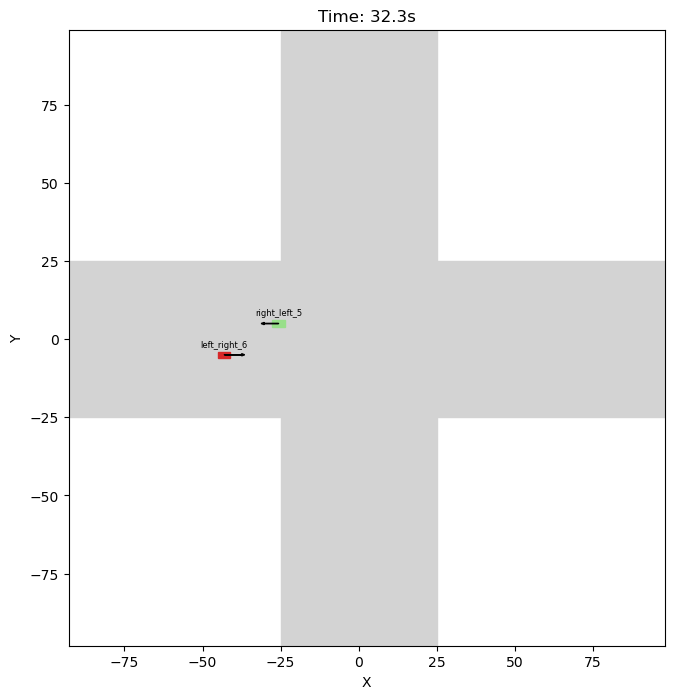

In [70]:
path_to_csv_data = r'csv/train_1k_simple_separate_10m'
output_video_name = "simple_separate_10m_intersection.mp4"

visualize_multiple_csvs_as_video(
    csv_folder=path_to_csv_data,
    output_video_path=output_video_name,
    interval_ms=100,
    max_frames=250  # optional lenght of the video in frames (None for all frames)
)


## Test inference with the model and visualize

In [3]:
import torch
from dataset import CarDataset
from model import GNN_mtl_gnn, GNN_mtl_mlp
from torch_geometric.loader import DataLoader

In [ ]:
# ----- Settings -----
weights_path = "trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth"
data_folder  = "csv/train_pre_1k_simple_separate_10m"
batch_size   = 32           # change if you run out of memory
use_mlp      = False         # True for MLP, False for GNN
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# ----- Load model -----
model = GNN_mtl_mlp(hidden_channels=128).to(device) if use_mlp else GNN_mtl_gnn(hidden_channels=128).to(device)
state = torch.load(weights_path, map_location=device)
model.load_state_dict(state)
model.eval()

# ----- Load data -----
ds = CarDataset(preprocess_folder=data_folder, plot=True, mlp=use_mlp, mpc_aug=True)
loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

Running on: cuda


In [ ]:
batch = next(iter(loader))

for i in range(len(batch)):
    print(batch[i])
    print(f"t: {batch[i].t}, edge_index: {batch[i].edge_index}, weights: {batch[i].weights}\n")


Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([0]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([0]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([0]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([0]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([1]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([1]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([1]), edge_index: tensor([[0],
        [0]]), weights:

In [16]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from glob import glob
from torch_geometric.data import Data
from model import GNN_mtl_gnn, GNN_mtl_mlp

def load_model(model_path, device, use_mlp=False, hidden_dim=128):
    cls = GNN_mtl_mlp if use_mlp else GNN_mtl_gnn
    model = cls(hidden_channels=hidden_dim).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    return model

def build_data_for_track(track_df, obs_len, device):
    """
    track_df: DataFrame of all past rows for one TRACK_ID.
    We take the last obs_len rows and build Data.x of shape [obs_len,7]:
      [X, Y, speed, yaw, int_left, int_right, int_straight]
    """
    df = track_df.sort_values('TIMESTAMP').tail(obs_len)
    # derive turning intent from ID string:
    tid = track_df['TRACK_ID'].iloc[0]
    if 'left' in tid:
        intent = [1, 0, 0]
    elif 'right' in tid:
        intent = [0, 1, 0]
    else:
        intent = [0, 0, 1]
    feats = []
    for _, row in df.iterrows():
        feats.append([
            float(row['X']),
            float(row['Y']),
            float(row['speed']),
            float(row['yaw']),
            *intent
        ])
    x = torch.tensor(feats, dtype=torch.float, device=device)
    edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
    return Data(x=x, edge_index=edge_index)

def predict_future(model, data, pred_len, dt):
    """
    Run model; then reshape to [1, pred_len, 2] and return list of (t, x, y).
    """
    with torch.no_grad():
        # pick only the 5 features [X, Y, int1, int2, int3]
        inp = data.x[:, [0, 1, 4, 5, 6]]
        out = model(inp, data.edge_index)        # now shapes match: (nodes x 5) @ (5 x hidden)
    out = out.reshape(-1, pred_len, 2)           # [1, pred_len, 2]
    preds = out[0].cpu().numpy()                 # [[x1,y1],…]
    last_t = data.x[-1, 0].item()
    return [(last_t + dt*(i+1), px, py)
            for i, (px, py) in enumerate(preds)]

def visualize_with_model(csv_folder,
                         model_path,
                         device,
                         obs_len,
                         pred_len,
                         dt,
                         output_video='predicted.mp4',
                         interval_ms=100,
                         max_frames=None):
    # read CSVs
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))
    if not all_csvs:
        print(f"No CSVs in {csv_folder}."); return

    dfs = []
    for p in all_csvs:
        tmp = pd.read_csv(p)
        tmp.columns = tmp.columns.str.strip()
        dfs.append(tmp)
    df = pd.concat(dfs, ignore_index=True)
    if 'TIMESTAMP' not in df.columns:
        print("Missing 'TIMESTAMP'. Got:", df.columns.tolist())
        return

    df = df.sort_values('TIMESTAMP')
    times = sorted(df['TIMESTAMP'].unique())
    if max_frames:
        times = times[:max_frames]

    model = load_model(model_path, device)
    model.eval()

    histories   = {}   # tid → DataFrame
    predictions = {}   # tid → [(t,x,y),...]

    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_aspect('equal')
    xmin, xmax = df['X'].min(), df['X'].max()
    ymin, ymax = df['Y'].min(), df['Y'].max()

    def update(i):
        t = times[i]
        ax.clear()
        ax.set_xlim(xmin-10, xmax+10);  ax.set_ylim(ymin-10, ymax+10)
        ax.set_title(f"Time: {t:.1f}s")
        ax.set_xlabel("X"); ax.set_ylabel("Y")

        # draw roads
        rw = 50
        ax.add_patch(plt.Rectangle((xmin-20, -rw/2), (xmax-xmin)+40, rw,
                                   color='lightgray', zorder=0))
        ax.add_patch(plt.Rectangle((-rw/2, ymin-20), rw, (ymax-ymin)+40,
                                   color='lightgray', zorder=0))

        now = df[df['TIMESTAMP']==t]
        for tid, grp in now.groupby('TRACK_ID'):
            histories.setdefault(tid, pd.DataFrame(columns=df.columns))
            histories[tid] = pd.concat([histories[tid], grp],
                                       ignore_index=True)
            if len(histories[tid])>=obs_len and tid not in predictions:
                data = build_data_for_track(histories[tid], obs_len, device)
                predictions[tid] = predict_future(model, data, pred_len, dt)

        for tid, hist in histories.items():
            gt = hist[hist['TIMESTAMP']==t]
            if not gt.empty:
                x, y = gt.iloc[0][['X','Y']]
            else:
                preds = predictions.get(tid, [])
                m = next((p for p in preds if abs(p[0]-t)<1e-6), None)
                if m is None:
                    continue
                _, x, y = m

            # plot car as point (replace with your rect+arrow)
            ax.scatter(x, y, s=20, zorder=2)

        return []

    ani = animation.FuncAnimation(fig, update,
                                  frames=len(times),
                                  interval=interval_ms,
                                  blit=False)
    ani.save(output_video, writer='ffmpeg',
             fps=1000//interval_ms)
    print(f"Saved to {output_video}")


Saved to model_prediction_2.mp4


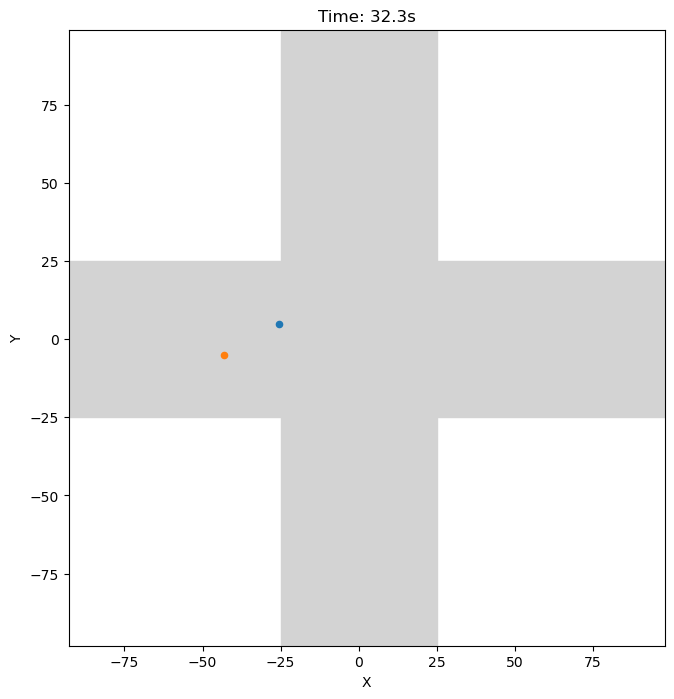

In [16]:
from utils.config import OBS_LEN, PRED_LEN, DT

# Example usage
csv_folder = 'csv/train_1k_simple_separate_10m'
model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
obs_len = OBS_LEN
pred_len = PRED_LEN
dt = DT

visualize_with_model(
    csv_folder=csv_folder,
    model_path=model_path,
    device=device,
    obs_len=obs_len,
    pred_len=pred_len,
    dt=dt,
    output_video='model_prediction_2.mp4',
    interval_ms=100,
    max_frames=250  # optional length of the video in frames (None for all frames)
)

In [1]:
import math, os
from glob import glob

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data

from model import GNN_mtl_gnn, GNN_mtl_mlp   # keep these as in your repo


# ------------------------------------------------------------------
# helpers
# ------------------------------------------------------------------
def build_graph(frame_df: pd.DataFrame) -> tuple:
    """
    Convert one timestamp of raw rows into a PyG Data object.
    Returns the graph and the TRACK_ID order.
    """
    n = len(frame_df)
    order = frame_df["TRACK_ID"].tolist()

    # node features: [x, y, speed, yaw(rad), int1, int2, int3]
    x_feat = torch.zeros((n, 7), dtype=torch.float32)
    x_feat[:, 0] = torch.tensor(frame_df["X"].values, dtype=torch.float32)
    x_feat[:, 1] = torch.tensor(frame_df["Y"].values, dtype=torch.float32)
    x_feat[:, 2] = torch.tensor(frame_df["speed"].values, dtype=torch.float32)
    x_feat[:, 3] = torch.deg2rad(torch.tensor(frame_df["yaw"].values, dtype=torch.float32))

    if n > 1:
        idx = torch.arange(n)
        edge_index = torch.cartesian_prod(idx, idx).T            # full graph
        edge_index = edge_index[:, edge_index[0] != edge_index[1]]  # drop self-loops
    else:
        edge_index = torch.zeros((2, 0), dtype=torch.long)

    return Data(x=x_feat, edge_index=edge_index), order


def rotation_matrix_back(yaw_tensor: torch.Tensor) -> torch.Tensor:
    """Rotation back to the global frame, shape (N, 2, 2)."""
    cos_y = torch.cos(-math.pi / 2 + yaw_tensor)
    sin_y = torch.sin(-math.pi / 2 + yaw_tensor)
    rot = torch.stack(
        [torch.stack([cos_y, -sin_y], dim=-1),
         torch.stack([sin_y,  cos_y], dim=-1)],
        dim=-2,
    )
    return rot

# ------------------------------------------------------------------
# main
# ------------------------------------------------------------------
def visualize_predictions(
    csv_folder: str,
    weights: str,
    mlp: bool = False,
    output_video_path: str = "intersection_pred.mp4",
    interval_ms: int = 100,
    pred_len: int = 30,
    device: str = "cpu",
    debug_angle: bool = False,
    debug_values: bool = False,
    start_time: float = None,   # first TIMESTAMP to show (seconds)
    end_time: float = None,     # last TIMESTAMP to show (seconds)
    duration: float = None,     # show this many seconds after start_time
):
    # ------------- model -----------------
    device = torch.device(device)
    Model = GNN_mtl_mlp if mlp else GNN_mtl_gnn
    model = Model(hidden_channels=128).to(device)
    model.load_state_dict(torch.load(weights, map_location=device))
    model.eval()

    # ------------- data ------------------
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))
    if not all_csvs:
        print("No CSV files found."); return

    df = pd.concat([pd.read_csv(p) for p in all_csvs])
    df.sort_values(by="TIMESTAMP", inplace=True)

    # time filter
    if duration is not None and start_time is not None:
        end_time = start_time + duration
    if start_time is not None:
        df = df[df["TIMESTAMP"] >= start_time]
    if end_time is not None:
        df = df[df["TIMESTAMP"] <= end_time]
    if df.empty:
        print("No frames left inside the chosen time window."); return

    timestamps = sorted(df["TIMESTAMP"].unique())
    dt = timestamps[1] - timestamps[0] if len(timestamps) > 1 else 0.1

    # last ground-truth time for every track
    track_end = df.groupby("TRACK_ID")["TIMESTAMP"].max().to_dict()

    colours = {tid: plt.cm.tab20(i % 20) for i, tid in enumerate(df["TRACK_ID"].unique())}
    grouped = df.groupby("TIMESTAMP")
    active: dict[str, dict] = {}          # live cars

    # ------------- plot ------------------
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(df["X"].min() - 10, df["X"].max() + 10)
    ax.set_ylim(df["Y"].min() - 10, df["Y"].max() + 10)
    ax.set_aspect("equal")

    # simple road backdrop
    road_w = 50
    road_rects = [
        plt.Rectangle((df["X"].min() - 20, -road_w / 2),
                      (df["X"].max() - df["X"].min()) + 40, road_w,
                      color="lightgray", zorder=0),
        plt.Rectangle((-road_w / 2, df["Y"].min() - 20),
                      road_w, (df["Y"].max() - df["Y"].min()) + 40,
                      color="lightgray", zorder=0),
    ]

    angle_log = []  # only if debug_angle

    # ------------- animation step ------------------
    def step(frame_idx: int):
        ts = timestamps[frame_idx]

        # add new cars that appear at this time stamp
        if ts in grouped.groups:
            for _, row in grouped.get_group(ts).iterrows():
                tid = row["TRACK_ID"]
                if tid not in active:         # brand-new ID
                    active[tid] = {
                        "x":   float(row["X"]),
                        "y":   float(row["Y"]),
                        "yaw": math.radians(row["yaw"]),
                        "spd": float(row["speed"]),
                        "last_ts": track_end[tid],
                    }

        # clear and redraw background
        ax.clear()
        ax.set_xlim(df["X"].min() - 10, df["X"].max() + 10)
        ax.set_ylim(df["Y"].min() - 10, df["Y"].max() + 10)
        ax.set_aspect("equal")
        ax.set_title(f"Time: {ts:.2f}s")
        for r in road_rects:
            ax.add_patch(r)

        gone = []  # tracks to remove after drawing

        # draw each live car
        for tid, info in active.items():
            x, y   = info["x"], info["y"]
            yaw    = info["yaw"]
            speed  = info["spd"]

            # body
            car = plt.Rectangle((x - 2, y - 1), 4, 2,
                                color=colours.get(tid, "gray"), zorder=1)
            car.set_transform(
                plt.matplotlib.transforms.Affine2D()
                .rotate_around(x, y, -yaw + math.pi / 2)
                + ax.transData
            )
            ax.add_patch(car)

            # tiny arrow
            arr_len = min(speed * 0.4, 10)
            ax.arrow(
                x, y,
                arr_len * math.cos(yaw - math.pi / 2),
                arr_len * math.sin(yaw - math.pi / 2),
                head_width=0.7, head_length=1.0, fc="black", ec="black"
            )

            ax.text(x, y + 2.5, tid, fontsize=6, ha="center")

            if ts >= info["last_ts"]:       # GT is over after this frame
                gone.append(tid)

        # predict one step for every live car
        if active:
            cur_df = pd.DataFrame([
                {
                    "TRACK_ID": t,
                    "X": info["x"],
                    "Y": info["y"],
                    "speed": info["spd"],
                    "yaw":  math.degrees(info["yaw"]),
                }
                for t, info in active.items()
            ])
            g_data, order = build_graph(cur_df)
            g_data = g_data.to(device)

            with torch.no_grad():
                raw = model(g_data.x[:, [0, 1, 4, 5, 6]], g_data.edge_index)

            # keep only the first future step
            raw = raw.reshape(-1, pred_len, 2)[:, 0]           # (N, 2) local
            rot = rotation_matrix_back(g_data.x[:, 3])         # (N, 2, 2)
            nxt = (rot @ raw.unsqueeze(-1)).squeeze(-1) + g_data.x[:, 0:2]

            # optionally log angles
            if debug_angle:
                disp = nxt - g_data.x[:, 0:2]
                angle_log.append(torch.atan2(disp[:, 1], disp[:, 0]))

            # update state so next frame starts here
            for i, tid in enumerate(order):
                px, py = active[tid]["x"], active[tid]["y"]
                nx, ny = nxt[i].cpu().numpy()
                active[tid]["x"], active[tid]["y"] = nx, ny
                active[tid]["yaw"] = math.atan2(ny - py, nx - px)
                active[tid]["spd"] = math.hypot(nx - px, ny - py) / dt

        # drop finished tracks
        for tid in gone:
            active.pop(tid, None)

        return []

    # ------------- run animation ---------------
    ani = animation.FuncAnimation(
        fig, step, frames=len(timestamps),
        init_func=lambda: [ax.add_patch(r) for r in road_rects],
        interval=interval_ms, blit=False
    )
    ani.save(output_video_path, writer="ffmpeg", fps=1000 // interval_ms)
    print(f"Video saved to {output_video_path}")

    # optional sanity check on angles
    if debug_angle and angle_log:
        all_ang = torch.cat(angle_log).cpu()
        bad = (all_ang.abs() > math.pi).sum().item()
        if bad:
            print(f"[WARN] {bad} step-wise headings outside ±180°")



/home/stud/vida/miniconda3/envs/MTP/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Video saved to model_prediction_7.mp4


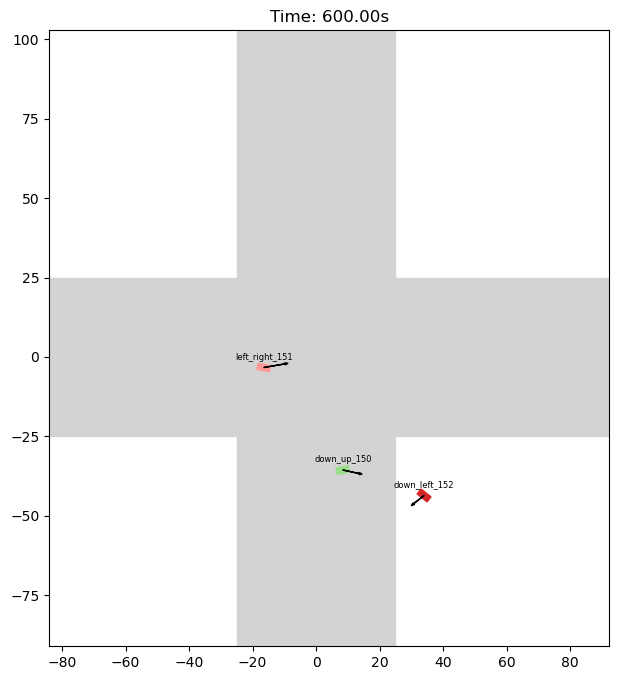

In [2]:
visualize_predictions(
    csv_folder = "csv/val_1k_simple_separate_10m",
    weights    = "trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth",
    mlp        = False,       # True if you want the MLP version
    output_video_path = "model_prediction_7.mp4",
    interval_ms = 100,
    pred_len    = 30,
    device      = "cuda",     # or "cpu"
    debug_values = False,
    debug_angle  = False,
    start_time = 480,         # first second to show (optional)
    duration   = 120          # seconds to play (optional)
)


In [12]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch_geometric.data import Data
import math

def load_model(model_path, device, use_mlp=False, hidden_dim=128):
    cls = GNN_mtl_mlp if use_mlp else GNN_mtl_gnn
    model = cls(hidden_channels=hidden_dim).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    return model

def rotation_matrix_back(yaw_tensor: torch.Tensor) -> torch.Tensor:
    """Rotation back to the global frame, shape (N, 2, 2)."""
    cos_y = torch.cos(-math.pi / 2 + yaw_tensor)
    sin_y = torch.sin(-math.pi / 2 + yaw_tensor)
    rot = torch.stack(
        [torch.stack([cos_y, -sin_y], dim=-1),
         torch.stack([sin_y,  cos_y], dim=-1)],
        dim=-2,
    )
    return rot

def build_data_for_track(track_df, obs_len, device):
    """
    track_df: DataFrame of all past rows for one TRACK_ID.
    We take the last obs_len rows and build Data.x of shape [obs_len,7]:
      [X, Y, speed, yaw, int_left, int_right, int_straight]
    """
    df = track_df.sort_values('TIMESTAMP').tail(obs_len)
    # derive turning intent from ID string:
    tid = track_df['TRACK_ID'].iloc[0]
    if 'left' in tid:
        intent = [1, 0, 0]
    elif 'right' in tid:
        intent = [0, 1, 0]
    else:
        intent = [0, 0, 1]
    feats = []
    for _, row in df.iterrows():
        feats.append([
            float(row['X']),
            float(row['Y']),
            float(row['speed']),
            float(row['yaw']),
            *intent
        ])
    x = torch.tensor(feats, dtype=torch.float, device=device)
    edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
    return Data(x=x, edge_index=edge_index)

def predict_future(model, data, pred_len, dt):
    """
    Run model; then reshape to [1, pred_len, 2] and return list of (t, x, y).
    """
    with torch.no_grad():
        # pick only the 5 features [X, Y, int1, int2, int3]
        inp = data.x[:, [0, 1, 4, 5, 6]]
        out = model(inp, data.edge_index)        # now shapes match: (nodes x 5) @ (5 x hidden)
    out = out.reshape(-1, pred_len, 2)           # [1, pred_len, 2]
    preds = out[0].cpu().numpy()                 # [[x1,y1],…]
    rotations = rotation_matrix_back(data.x[:, 3])  # [N, 2, 2]
    last_t = data.x[-1, 0].item()
    return [(last_t + dt*(i+1), px, py)
            for i, (px, py) in enumerate(preds)]

csv_folder = 'csv/train_1k_simple_separate_10m'

# read CSVs
all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))
if not all_csvs:
    print(f"No CSVs in {csv_folder}.")
    exit()

dfs = []
for p in all_csvs:
    tmp = pd.read_csv(p)
    tmp.columns = tmp.columns.str.strip()
    dfs.append(tmp)
df = pd.concat(dfs, ignore_index=True)
if 'TIMESTAMP' not in df.columns:
    print("Missing 'TIMESTAMP'. Got:", df.columns.tolist())
    exit()

df = df.sort_values('TIMESTAMP')
times = sorted(df['TIMESTAMP'].unique())

In [12]:
df

,Unnamed: 0,TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,yaw,speed,CITY_NAME
0,167,7.4,down_up_1,tgt,5.0,-53.36,0.0,12.68,SUMO
1,171,7.5,down_up_1,tgt,5.0,-52.07,0.0,12.88,SUMO
2,175,7.6,down_up_1,tgt,5.0,-50.77,0.0,12.98,SUMO
3,179,7.7,down_up_1,tgt,5.0,-49.48,0.0,12.98,SUMO
4,183,7.8,down_up_1,tgt,5.0,-48.18,0.0,12.99,SUMO
...,...,...,...,...,...,...,...,...,...
43757,635,997.2,left_down_260,tgt,-21.6,-5.00,90.0,0.00,SUMO
43758,636,997.2,left_right_259,tgt,-14.1,-5.00,90.0,0.00,SUMO
43759,637,997.2,right_down_232,tgt,14.1,5.00,270.0,0.00,SUMO
43760,638,997.2,right_left_237,tgt,21.6,5.00,270.0,0.00,SUMO


In [13]:
# Print the output of the model
model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
obs_len = 30  # Number of past frames to consider
pred_len = 30  # Number of future frames
dt = times[1] - times[0] if len(times) > 1 else 0.1
model = load_model(model_path, device)
model.eval()
histories = {}   # tid → DataFrame
predictions = {}   # tid → [(t,x,y)]

data  = build_data_for_track(df, obs_len, device)
preds = predict_future(model, data, pred_len, dt)

# Print the predictions
for t, x, y in preds:
    print(f"Time: {t:.2f}, X: {x:.2f}, Y: {y:.2f}")
    

Time: -4.90, X: 0.65, Y: 1.34
Time: -4.80, X: 0.38, Y: 1.95
Time: -4.70, X: 0.58, Y: 3.58
Time: -4.60, X: 0.95, Y: 5.23
Time: -4.50, X: 1.14, Y: 6.20
Time: -4.40, X: 2.12, Y: 7.48
Time: -4.30, X: 2.70, Y: 8.95
Time: -4.20, X: 2.59, Y: 9.69
Time: -4.10, X: 3.31, Y: 11.19
Time: -4.00, X: 3.36, Y: 12.98
Time: -3.90, X: 2.95, Y: 13.36
Time: -3.80, X: 3.85, Y: 14.72
Time: -3.70, X: 4.20, Y: 15.93
Time: -3.60, X: 4.34, Y: 17.60
Time: -3.50, X: 4.59, Y: 18.98
Time: -3.40, X: 4.91, Y: 20.37
Time: -3.30, X: 4.22, Y: 21.30
Time: -3.20, X: 5.62, Y: 21.89
Time: -3.10, X: 4.96, Y: 23.70
Time: -3.00, X: 5.92, Y: 24.49
Time: -2.90, X: 5.65, Y: 25.27
Time: -2.80, X: 6.30, Y: 26.50
Time: -2.70, X: 6.23, Y: 27.06
Time: -2.60, X: 5.93, Y: 27.67
Time: -2.50, X: 7.06, Y: 28.97
Time: -2.40, X: 7.66, Y: 29.96
Time: -2.30, X: 6.66, Y: 30.29
Time: -2.20, X: 8.53, Y: 31.60
Time: -2.10, X: 7.93, Y: 32.46
Time: -2.00, X: 7.88, Y: 32.89


In [45]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8, 8))

def update(i):
    ax.clear()
    sample = df[df['TIMESTAMP'] == times[i]]
    if sample.empty:
        print(f"No data available for timestamp {times[i]:.2f}")
        return []
    data = build_data_for_track(sample, obs_len, device)
    predictions = predict_future(model, data, pred_len, dt)
    ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
    ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
    ax.set_aspect('equal')
    track_id = sample['TRACK_ID'].values[0]
    timestamp = times[i]
    ax.set_title(f"Track ID: {track_id}, Time: {timestamp:.2f}s")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    x_sample = sample['X'].values[0]
    y_sample = sample['Y'].values[0]
    scat_sample = ax.scatter(x_sample, y_sample, color='red', label='Sample Data', s=100)
    scat_preds = []
    for idx, (t, x_pred, y_pred) in enumerate(predictions):
        scat_preds.append(ax.scatter(x_pred, y_pred, color='blue', label='Predictions' if idx == 0 else "", s=50))
    if len(predictions) > 0:
        ax.legend()
    return [scat_sample] + scat_preds

# Use more frames for a longer video
num_frames = min(len(times), 500)  # or use len(times) for the full dataset
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=100, blit=False)
ani.save('track_predictions_long.mp4', writer='ffmpeg', fps=10)
plt.close(fig)
print("Video saved as track_predictions_long.mp4")


Video saved as track_predictions_long.mp4


In [15]:
# Plot for only one track

# Make n videos, each for a different car (TRACK_ID)
n = 5  # number of cars to plot (change as needed)
unique_track_ids = df['TRACK_ID'].unique()[:n]

for track_id in unique_track_ids:
    track_df = df[df['TRACK_ID'] == track_id].sort_values('TIMESTAMP')
    track_times = track_df['TIMESTAMP'].unique()
    fig, ax = plt.subplots(figsize=(8, 8))

    def update(i):
        ax.clear()
        sample = track_df[track_df['TIMESTAMP'] == track_times[i]]
        if sample.empty:
            print(f"No data available for timestamp {track_times[i]:.2f}")
            return []
        data = build_data_for_track(sample, obs_len, device)
        predictions = predict_future(model, data, pred_len, dt)
        ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
        ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
        ax.set_aspect('equal')
        timestamp = track_times[i]
        ax.set_title(f"Track ID: {track_id}, Time: {timestamp:.2f}s")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        x_sample = sample['X'].values[0]
        y_sample = sample['Y'].values[0]
        scat_sample = ax.scatter(x_sample, y_sample, color='red', label='Sample Data', s=100)
        scat_preds = []
        for idx, (t, x_pred, y_pred) in enumerate(predictions):
            scat_preds.append(ax.scatter(x_pred, y_pred, color='blue', label='Predictions' if idx == 0 else "", s=50))
        if len(predictions) > 0:
            ax.legend()
        return [scat_sample] + scat_preds

    num_frames = min(len(track_times), 500)
    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=100, blit=False)
    video_filename = f'track_predictions_{track_id}.mp4'
    ani.save(video_filename, writer='ffmpeg', fps=10)
    plt.close(fig)
    print(f"Video saved as {video_filename}")

Video saved as track_predictions_down_up_1.mp4
Video saved as track_predictions_down_left_2.mp4
Video saved as track_predictions_up_down_0.mp4
Video saved as track_predictions_down_up_3.mp4
Video saved as track_predictions_left_right_4.mp4


In [47]:
# ------------- set-up -----------------
obs_len   = 20          # whatever you trained with
pred_len  = 1           # we only need the next step for feedback
dt        = 0.1         # time step between rows (s)
num_frames = 500        # how long you want the movie

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model  = load_model('trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth', device)

# ------------- seed -------------------
start_df = df.sort_values('TIMESTAMP').head(1)        # very first row of this track
history  = start_df.copy()                            # will grow over time
frames   = [start_df]                                 # one-row snapshots for the animator

data = build_data_for_track(history, obs_len, device) # first input to the net

# ------------- roll forward -----------
def add_pred_row(hist, pred, dt):
    """Append one predicted (t,x,y) triple as a new row."""
    t, x, y = pred
    last_x, last_y = hist.iloc[-1][['X', 'Y']]
    speed = ((x - last_x)**2 + (y - last_y)**2)**0.5 / dt
    new_row = {
        'TIMESTAMP'  : t,
        'TRACK_ID'   : hist['TRACK_ID'].iloc[0],
        'OBJECT_TYPE': hist['OBJECT_TYPE'].iloc[0],
        'X'          : x,
        'Y'          : y,
        'yaw'        : 0.0,          # quick placeholder
        'speed'      : speed,
        'CITY_NAME'  : hist['CITY_NAME'].iloc[0],
    }
    return hist.append(new_row, ignore_index=True)

for k in range(num_frames - 1):
    # model returns a list of (t,x,y); we feed back only the very next step
    next_step = predict_future(model, data, pred_len=1, dt=dt)[0]
    history   = add_pred_row(history, next_step, dt)
    data      = build_data_for_track(history, obs_len, device)
    frames.append(history.tail(1))   # keep only the fresh row for plotting

# ------------- animation --------------
fig, ax = plt.subplots(figsize=(8, 8))

def update(i):
    ax.clear()
    sample = frames[i]                   # one-row DataFrame
    x, y   = sample['X'].values[0], sample['Y'].values[0]

    # plot history path so far
    ax.plot(history.loc[:sample.index[0], 'X'],
            history.loc[:sample.index[0], 'Y'],
            lw=2, alpha=0.3)

    # current point
    scat = ax.scatter(x, y, c='red', s=100)

    ax.set_title(f"Track: {sample['TRACK_ID'].values[0]} | t = {sample['TIMESTAMP'].values[0]:.2f}s")
    ax.set_xlabel('X'); ax.set_ylabel('Y')
    ax.set_aspect('equal')
    ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
    ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
    return [scat]

ani = animation.FuncAnimation(fig, update, frames=len(frames),
                              interval=100, blit=False)
ani.save('track_predictions_long_2.mp4', writer='ffmpeg', fps=10)
plt.close(fig)
print("Video saved.")


Video saved.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
from glob import glob

def load_model(model_path, device, use_mlp=False, hidden_dim=128):
    cls = GNN_mtl_mlp if use_mlp else GNN_mtl_gnn
    model = cls(hidden_channels=hidden_dim).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    return model

def rotation_matrix_back(yaw_tensor: torch.Tensor) -> torch.Tensor:
    """Rotation back to the global frame, shape (N, 2, 2)."""
    cos_y = torch.cos(-math.pi / 2 + yaw_tensor)
    sin_y = torch.sin(-math.pi / 2 + yaw_tensor)
    rot = torch.stack(
        [torch.stack([cos_y, -sin_y], dim=-1),
         torch.stack([sin_y,  cos_y], dim=-1)],
        dim=-2,
    )
    return rot

def build_data_for_track(track_df, obs_len, device):
    """
    track_df: DataFrame of all past rows for one TRACK_ID.
    We take the last obs_len rows and build Data.x of shape [obs_len,7]:
      [X, Y, speed, yaw, int_left, int_right, int_straight]
    """
    df = track_df.sort_values('TIMESTAMP').tail(obs_len)
    # derive turning intent from ID string:
    tid = track_df['TRACK_ID'].iloc[0]
    if 'left' in tid:
        intent = [1, 0, 0]
    elif 'right' in tid:
        intent = [0, 1, 0]
    else:
        intent = [0, 0, 1]
    feats = []
    for _, row in df.iterrows():
        feats.append([
            float(row['X']),
            float(row['Y']),
            float(row['speed']),
            float(row['yaw']),
            *intent
        ])
    x = torch.tensor(feats, dtype=torch.float, device=device)
    edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
    return Data(x=x, edge_index=edge_index)

def visualize_multiple_csvs_as_video(csv_folder, model, output_video_path='intersection.mp4', interval_ms=100, max_frames=None):
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

    if not all_csvs:
        print("No CSV files found.")
        return

    df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
    df = df.sort_values(by='TIMESTAMP')

    # Normalize track IDs to assign each car a unique color
    track_ids = df['TRACK_ID'].unique()
    colors = {track_id: plt.cm.tab20(i % 20) for i, track_id in enumerate(track_ids)}

    grouped = df.groupby('TIMESTAMP')

    # Group by timestamp
    timestamps = sorted(df['TIMESTAMP'].unique())

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
    ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
    ax.set_aspect('equal')

    # This function initializes the plot by creating an empty list
    # that will be used to store the artists (plot elements) for each frame.
    def init():
        return []

    # This function updates the plot for each frame.
    def update(frame_idx):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
        ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
        ax.set_title(f"Time: {ts:.1f}s")
        ax.set_xlabel("X [m]")
        ax.set_ylabel("Y [m]")
        ax.set_aspect('equal')

        if ts not in grouped.groups:
            return []

        frame_df = grouped.get_group(ts)

        # Draw vehicles
        for _, row in frame_df.iterrows():
            x = float(row['X'])
            y = float(row['Y'])
            track_id = row['TRACK_ID']
            yaw_deg = float(row['yaw'])
            speed = float(row['speed'])
            color = colors.get(track_id, 'gray')

            # Heading for arrow (correct as is)
            heading_arrow = np.deg2rad(yaw_deg + 90)

            # Vehicle rotation (flipped horizontally)
            heading_rect = -heading_arrow

            length = 4
            width = 2
            dx = -length / 2
            dy = -width / 2

            rect = plt.Rectangle((x + dx, y + dy), length, width,
                                color=color, zorder=1)
            transform = plt.matplotlib.transforms.Affine2D().rotate_around(x, y, heading_rect) + ax.transData
            rect.set_transform(transform)
            ax.add_patch(rect)

            arrow_length = min(speed * 0.4, 10)
            ax.arrow(x, y,
                    -arrow_length * np.cos(heading_arrow),
                    arrow_length * np.sin(heading_arrow),
                    head_width=0.7,
                    head_length=1.0,
                    fc='black',
                    ec='black',
                    zorder=2)

            ax.text(x, y + 2.5, str(track_id), fontsize=6, ha='center', zorder=3)

        return []


    ani = animation.FuncAnimation(fig, update, frames=len(timestamps), init_func=init, interval=interval_ms, blit=False)
    ani.save(output_video_path, writer='ffmpeg', fps=1000 // interval_ms)
    print(f"Video saved to {output_video_path}")


NameError: name 'torch' is not defined

In [ ]:
csv_folder = 'csv/val_1k_simple_separate_10m'

all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

if not all_csvs:
    print("No CSV files found.")

df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
df = df.sort_values(by='TIMESTAMP')

# Use track IDs to assign each car a unique color
track_ids = df['TRACK_ID'].unique()
colors = {track_id: plt.cm.tab20(i % 20) for i, track_id in enumerate(track_ids)}

In [8]:
df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
df

,Unnamed: 0,TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,yaw,speed,CITY_NAME
0,167,7.4,down_up_1,tgt,5.0,-53.40,0.0,12.49,SUMO
1,171,7.5,down_up_1,tgt,5.0,-52.14,0.0,12.62,SUMO
2,175,7.6,down_up_1,tgt,5.0,-50.86,0.0,12.78,SUMO
3,179,7.7,down_up_1,tgt,5.0,-49.57,0.0,12.98,SUMO
4,183,7.8,down_up_1,tgt,5.0,-48.28,0.0,12.91,SUMO
...,...,...,...,...,...,...,...,...,...
95,332,999.6,left_right_263,tgt,-14.1,-5.00,90.0,0.00,SUMO
96,338,999.7,left_down_264,tgt,-21.6,-5.00,90.0,0.00,SUMO
97,339,999.7,left_right_263,tgt,-14.1,-5.00,90.0,0.00,SUMO
98,345,999.8,left_down_264,tgt,-21.6,-5.00,90.0,0.00,SUMO


In [ ]:
import os, math
from collections import deque
from glob import glob

import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from dataset import CarDataset
from model import GNN_mtl_gnn, GNN_mtl_mlp
from torch_geometric.loader import DataLoader 



# ──────────────────────────────
#  1.  helpers
# ──────────────────────────────
def load_model(model_path, device, use_mlp=False, hidden_dim=128):
    cls = GNN_mtl_mlp if use_mlp else GNN_mtl_gnn
    model = cls(hidden_channels=hidden_dim).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model


def rotation_matrix_back(yaw: torch.Tensor) -> torch.Tensor:        # (N,) → (N,2,2)
    cos_y = torch.cos(-math.pi / 2 + yaw)
    sin_y = torch.sin(-math.pi / 2 + yaw)
    return torch.stack(
        [torch.stack([cos_y, -sin_y], dim=-1),
         torch.stack([sin_y,  cos_y], dim=-1)],
        dim=-2,
    )


def build_data_for_track(track_rows, obs_len, device):
    """
    track_rows: deque with dict-like rows (last obs_len already kept in order).
    Creates Data.x  [obs_len, 7]  =  [X, Y, speed, yaw, int_left, int_right, int_straight]
    """
    # build intent flags from the first stored row
    tid = track_rows[0]['TRACK_ID']
    if 'left' in tid:
        intent = [1, 0, 0]
    elif 'right' in tid:
        intent = [0, 1, 0]
    else:
        intent = [0, 0, 1]

    feats = [[r['X'], r['Y'], r['speed'], r['yaw'], *intent] for r in track_rows]
    x = torch.tensor(feats, dtype=torch.float, device=device)
    edge_index = torch.empty((2, 0), dtype=torch.long, device=device)     # no graph edges here
    return Data(x=x, edge_index=edge_index)


def predict_step(model, data, dt):
    """
    Runs the net and returns the *first* predicted point in *global* co-ordinates.
    """
    with torch.no_grad():
        inp = data.x[:, [0, 1, 4, 5, 6]]          # (obs_len,5)
        rel_out = model(inp, data.edge_index)     # (obs_len,2) – last row is next step (by design)
    rel_vec = rel_out[-1]                         # (2,)
    # rotate to global:
    yaw_last = data.x[-1, 3]                      # scalar
    rot = rotation_matrix_back(yaw_last)[0]       # (2,2)
    dx, dy = (rot @ rel_vec).cpu().numpy()        # (2,)

    x_prev, y_prev = data.x[-1, 0].item(), data.x[-1, 1].item()
    return x_prev + dx, y_prev + dy
# ──────────────────────────────



# ──────────────────────────────
#  2.  main routine
# ──────────────────────────────
def visualize_with_prediction(
        csv_folder,
        model_path,
        output_video_path='simulation.mp4',
        device='cpu',
        obs_len=6,
        dt=0.1,
        interval_ms=100):

    # ▸ collect CSV rows once
    all_csvs = sorted(glob(os.path.join(csv_folder, '*.csv')))
    if not all_csvs:
        print('No CSV files found.');  return

    df = pd.concat(pd.read_csv(p) for p in all_csvs).sort_values('TIMESTAMP')
    timestamps = sorted(df['TIMESTAMP'].unique())

    # ▸ remember the last csv time-stamp for every id (used to know when to stop predicting)
    last_csv_ts = df.groupby('TRACK_ID')['TIMESTAMP'].max().to_dict()

    # ▸ load network
    model = load_model(model_path, device)

    # ▸ active tracks: id → deque(history)
    tracks = {}

    # ▸ colors
    track_ids_all = df['TRACK_ID'].unique()
    colors = {tid: plt.cm.tab20(i % 20) for i, tid in enumerate(track_ids_all)}

    # ▸ figure
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_xlabel('X');  ax.set_ylabel('Y')

    # axis limits once
    ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
    ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)

    def update(frame_idx):
        ts = timestamps[frame_idx]
        ax.cla()
        ax.set_title(f'Time: {ts:.1f}s')
        ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
        ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
        ax.set_aspect('equal')
        ax.set_xlabel('X');  ax.set_ylabel('Y')

        # paint simple cross-road (same as your first script)
        road_w = 50
        ax.add_patch(plt.Rectangle((df['X'].min() - 20, -road_w / 2),
                                   (df['X'].max() - df['X'].min()) + 40,
                                   road_w, color='lightgray', zorder=0))
        ax.add_patch(plt.Rectangle((-road_w / 2, df['Y'].min() - 20),
                                   road_w,
                                   (df['Y'].max() - df['Y'].min()) + 40,
                                   color='lightgray', zorder=0))

        # ▸ rows that *actually* exist in the CSV at this ts
        for _, row in df[df['TIMESTAMP'] == ts].iterrows():
            tid = row['TRACK_ID']
            # seen for the first time → start history with that row
            if tid not in tracks:
                tracks[tid] = deque(maxlen=obs_len)
            tracks[tid].append(row)

        # ▸ predict / draw each active id
        inactive = []          # ids to drop after drawing
        for tid, hist in tracks.items():
            # stop if movie has reached the id’s last csv time-stamp
            if ts > last_csv_ts[tid]:
                inactive.append(tid)
                continue

            # decide position for this frame
            if len(hist) < obs_len:
                # not enough history yet → use last real row
                x, y = hist[-1]['X'], hist[-1]['Y']
                yaw = hist[-1]['yaw']
                speed = hist[-1]['speed']
            else:
                # predict one step ahead
                data = build_data_for_track(list(hist), obs_len, device)
                x, y = predict_step(model, data, dt)
                # crude yaw / speed update (based on delta). Optional.
                dx = x - hist[-1]['X'];   dy = y - hist[-1]['Y']
                yaw = math.degrees(math.atan2(dy, dx)) - 90          # keep same convention
                speed = math.hypot(dx, dy) / dt
                hist.append({**hist[-1], 'X': x, 'Y': y, 'yaw': yaw, 'speed': speed, 'TIMESTAMP': ts})

            color = colors.get(tid, 'gray')

            # draw car body
            length, width = 4, 2
            dx_rect, dy_rect = -length / 2, -width / 2
            rect = plt.Rectangle((x + dx_rect, y + dy_rect), length, width,
                                 color=color, zorder=1)
            heading = np.deg2rad(-(yaw + 90))            # rotation as in first script
            trans = plt.matplotlib.transforms.Affine2D().rotate_around(x, y, heading) + ax.transData
            rect.set_transform(trans)
            ax.add_patch(rect)

            # draw heading arrow
            arrow_len = min(speed * 0.4, 10)
            heading_arrow = np.deg2rad(yaw + 90)
            ax.arrow(x, y,
                     -arrow_len * np.cos(heading_arrow),
                      arrow_len * np.sin(heading_arrow),
                     head_width=0.7, head_length=1.0,
                     fc='black', ec='black', zorder=2)

            ax.text(x, y + 2.5, str(tid), fontsize=6, ha='center', zorder=3)

        # drop finished ids
        for tid in inactive:
            tracks.pop(tid, None)

        return []


    ani = animation.FuncAnimation(fig, update,
                                  frames=len(timestamps),
                                  interval=interval_ms,
                                  blit=False)
    ani.save(output_video_path, writer='ffmpeg', fps=1000 // interval_ms)
    print(f'Video saved to {output_video_path}')


/home/stud/vida/miniconda3/envs/MTP/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: inconsistent tensor size, expected tensor [2] and src [60] to have the same number of elements, but got 2 and 60 elements respectively

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x75db0204f830> (for post_execute):


RuntimeError: inconsistent tensor size, expected tensor [2] and src [60] to have the same number of elements, but got 2 and 60 elements respectively

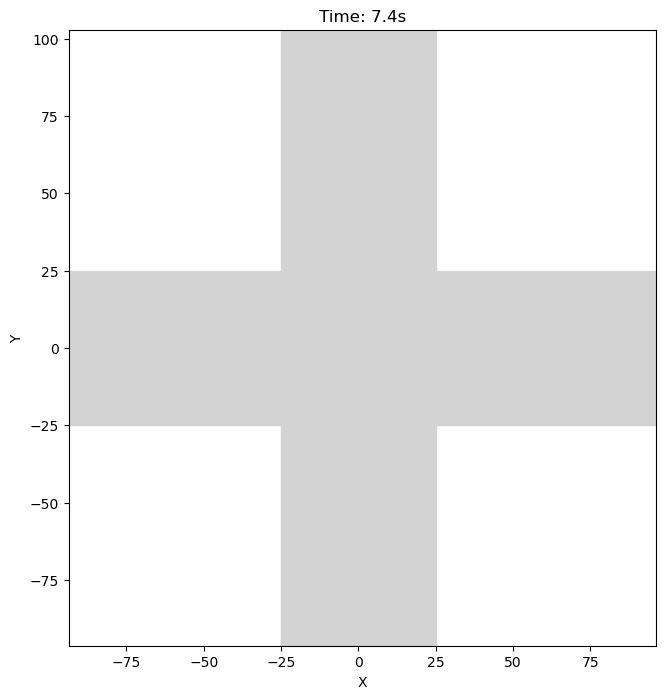

In [2]:
visualize_with_prediction(
    csv_folder='csv/val_1k_simple_separate_10m',
    model_path='trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth',
    output_video_path='model_predictions_8.mp4',
    device='cuda',      # or 'cpu'
    obs_len=6,
    dt=0.1,               # sec between time-steps in your data
    interval_ms=100       # animation speed (100 ms → 10 fps)
)
